In [1]:
import numpy as np, pandas as pd, seaborn as sns, matplotlib.pyplot as plt
pd.pandas.set_option('display.max_columns',None)

In [2]:
df = pd.read_csv('WA_Fn-UseC_-HR-Employee-Attrition.csv')

In [3]:
df.shape

(1470, 35)

## Missing values

In [4]:
df.isnull().any().any()

False

## Attrition Distribution

In [5]:
df.Attrition.value_counts()

No     1233
Yes     237
Name: Attrition, dtype: int64

## Correlation Map

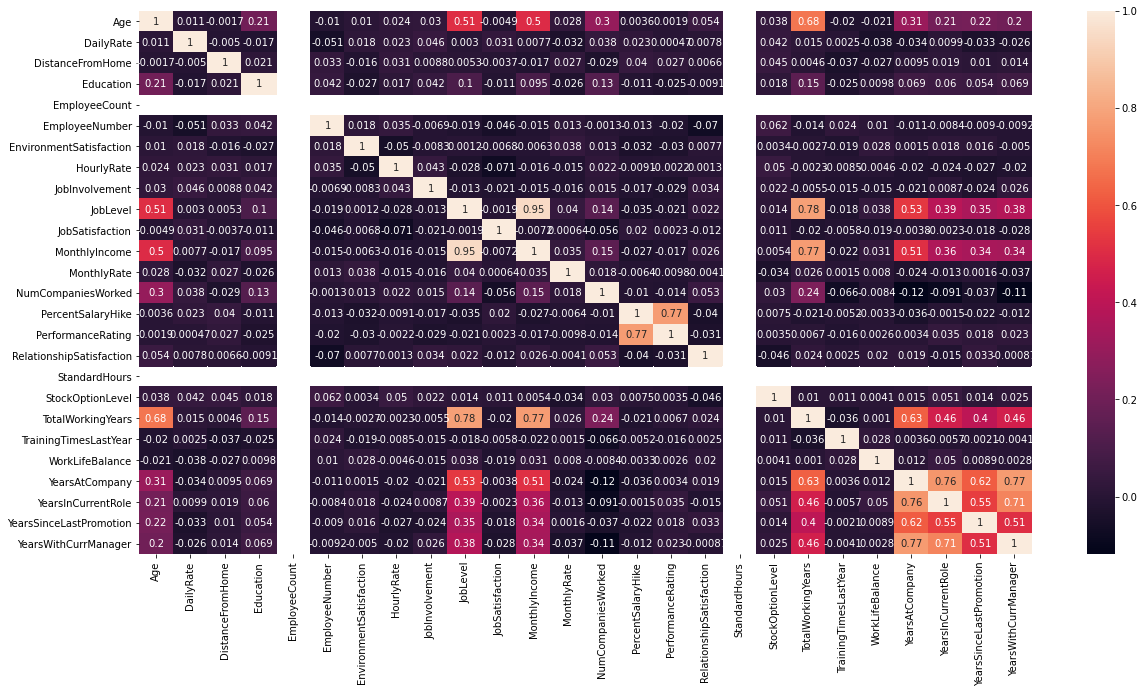

In [6]:
plt.figure(figsize=(20,10))
sns.heatmap(df.corr(),annot=True)

## Removing constant values

In [7]:
df = df.drop(labels=['EmployeeCount','EmployeeNumber','Over18','StandardHours'],axis=1)

## Splitting Dataset

In [8]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test=train_test_split(df.drop(labels=['Attrition'],axis=1),
                                               df['Attrition'],
                                               test_size=0.3,
                                               stratify=df['Attrition'],
                                              random_state=100)

In [9]:
X_train.reset_index(drop=True).to_csv('Data/X_train_org.csv',index=False)
X_test.reset_index(drop=True).to_csv('Data/X_test_org.csv',index=False)

In [10]:
y_train.reset_index(drop=True).to_csv('Data/y_train_org.csv',index=False)
y_test.reset_index(drop=True).to_csv('Data/y_test_org.csv',index=False)

# Encoding

In [11]:
## Label Encoding Attrition

attrition_map = {
    'Yes' : 1,
    'No' : 0
}

y_train = y_train.map(attrition_map)
y_test = y_test.map(attrition_map)

In [ ]:
X_train['BusinessTravel'].unique()

In [ ]:
## Label encoding 'BusinessTravel' as it is Ordinal feature

businessTravel_map = {
    'Travel_Frequently' : 2,
    'Travel_Rarely' : 1,
    'Non-Travel' : 0
}

X_train['BusinessTravel'] = X_train['BusinessTravel'].map(businessTravel_map)
X_test['BusinessTravel'] = X_test['BusinessTravel'].map(businessTravel_map)

In [ ]:
from sklearn.preprocessing import OneHotEncoder

In [ ]:
nominal_categories = ['Department','EducationField','Gender','JobRole','MaritalStatus','OverTime']

train_nominal_cat = pd.get_dummies(data=X_train[nominal_categories],drop_first=True)

In [ ]:
train_enc_nominal_cat = dict()

for col in train_nominal_cat.columns.values:
    splitted = col.split('_')
    if(splitted[0] not in train_enc_nominal_cat):
        train_enc_nominal_cat[splitted[0]] = []
    train_enc_nominal_cat[splitted[0]].append(splitted[1])
train_enc_nominal_cat

In [ ]:
test_nominal_cat = pd.get_dummies(data=X_test[nominal_categories],drop_first=True)

test_enc_nominal_cat = dict()

for col in test_nominal_cat.columns.values:
    splitted = col.split('_')
    if(splitted[0] not in test_enc_nominal_cat):
        test_enc_nominal_cat[splitted[0]] = []
    test_enc_nominal_cat[splitted[0]].append(splitted[1])
test_enc_nominal_cat

In [ ]:
shared_items = {k: train_enc_nominal_cat[k] for k in train_enc_nominal_cat if k in test_enc_nominal_cat and train_enc_nominal_cat[k] == test_enc_nominal_cat[k]}

print('Difference between categories encoded between training and test:',len(train_enc_nominal_cat)-len(shared_items))

In [ ]:
X_train = pd.concat([X_train.reset_index(drop=True),train_nominal_cat.reset_index(drop=True)],axis=1)
X_train = X_train.drop(labels=nominal_categories,axis=1)
X_train.head()

In [ ]:
X_test = pd.concat([X_test.reset_index(drop=True),test_nominal_cat.reset_index(drop=True)],axis=1)
X_test = X_test.drop(labels=nominal_categories,axis=1)
X_test.head()

In [ ]:
X_train.shape,X_test.shape

In [ ]:
y_train.shape,y_test.shape

### Save Encoded Data 

In [ ]:
X_train.to_csv('Data/X_train_enc.csv',index=False)
X_test.to_csv('Data/X_test_enc.csv',index=False)
y_train.to_csv('Data/y_train_enc.csv',index=False)
y_test.to_csv('Data/y_test_enc.csv',index=False)

In [ ]:
df = pd.concat([X_train,y_train],axis=1)
df.shape

## Correlation Analysis

In [ ]:
cols = ['DailyRate','DistanceFromHome','Education',
        'EnvironmentSatisfaction','HourlyRate','JobInvolvement',
        'JobLevel','JobSatisfaction','MonthlyIncome','MonthlyRate',
        'NumCompaniesWorked','PercentSalaryHike','PerformanceRating',
        'RelationshipSatisfaction','StockOptionLevel','TotalWorkingYears',
        'TrainingTimesLastYear','WorkLifeBalance','YearsAtCompany','YearsInCurrentRole',
        'YearsSinceLastPromotion','YearsWithCurrManager']

In [ ]:
plt.figure(figsize=(20,15))
sns.heatmap(df[cols].corr(),annot=True)

In [ ]:
def correlated_features(dataset,threshold,method='pearson'):
    col_corr = []
    cor_matrix = dataset.corr(method=method)
    for i in range(len(cor_matrix.columns)):
        for j in range(i):
            if abs(cor_matrix.iloc[i,j]) > threshold:
                colname = cor_matrix.columns[i]
                col_corr.append(colname)
    return col_corr

In [ ]:
corr_features = correlated_features(df[cols],0.8)
print(len(corr_features))
for feat in corr_features:
    print(feat)

## ML

In [12]:
X = pd.read_csv('Data/X_train_enc.csv')
y = pd.read_csv('Data/y_train_enc.csv')

X_test = pd.read_csv('Data/X_test_enc.csv')
y_test = pd.read_csv('Data/y_test_enc.csv')

In [13]:
X.shape,y.shape,X_test.shape,y_test.shape

((1029, 43), (1029, 1), (441, 43), (441, 1))

In [14]:
import imblearn
print(imblearn.__version__)

0.7.0


In [15]:
from imblearn.over_sampling import ADASYN

In [16]:
X, y = ADASYN().fit_resample(X, y)

In [17]:
X.shape,y.shape

((1685, 43), (1685, 1))

In [18]:
from sklearn.ensemble import StackingClassifier, RandomForestClassifier,AdaBoostClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from xgboost import XGBClassifier
import lightgbm as lgb
from sklearn.tree import DecisionTreeClassifier

In [19]:
rfc = RandomForestClassifier()
ada = AdaBoostClassifier()
gbc = GradientBoostingClassifier()
lr = LogisticRegression()
svc = SVC()
gnb = GaussianNB()
xgb = XGBClassifier()
dt = DecisionTreeClassifier()

In [20]:
estimators = [
    ('ada',ada),
    
    ('gbc',gbc),
    ('lr',lr),
    ('svc',svc),
    
    ('gnb',gnb),
    
    ('xgb',xgb),
    
    ('dt',dt)
]

In [21]:
stk_classifier = StackingClassifier(estimators=estimators, 
                                    final_estimator=RandomForestClassifier(n_estimators=100),
                                    passthrough=True,
                                    cv=5,
                                    n_jobs=-1,
                                    verbose=3)

In [26]:
stk_classifier.fit(X,y['Attrition'])

StackingClassifier(cv=5,
                   estimators=[('ada', AdaBoostClassifier()),
                               ('gbc', GradientBoostingClassifier()),
                               ('lr', LogisticRegression()), ('svc', SVC()),
                               ('gnb', GaussianNB()),
                               ('xgb',
                                XGBClassifier(base_score=None, booster=None,
                                              colsample_bylevel=None,
                                              colsample_bynode=None,
                                              colsample_bytree=None, gamma=None,
                                              gpu_id=None,
                                              importance_type='gain',
                                              interaction_constraint...
                                              min_child_weight=None,
                                              missing=nan,
                                              m

In [24]:
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score,fbeta_score

In [27]:
y_pred = stk_classifier.predict(X_test)
print('Accuracy:',accuracy_score(y_test,y_pred))
print(confusion_matrix(y_test,y_pred))
print(classification_report(y_test,y_pred))

Accuracy: 0.8775510204081632
[[356  14]
 [ 40  31]]
              precision    recall  f1-score   support

           0       0.90      0.96      0.93       370
           1       0.69      0.44      0.53        71

    accuracy                           0.88       441
   macro avg       0.79      0.70      0.73       441
weighted avg       0.87      0.88      0.87       441



In [28]:
import pickle
pickle.dump(stk_classifier, open('stk_final1', 'wb'))